# 🔁 PyTorch Conversion of Dummy TensorFlow Notebook with 10×10 CV

In [1]:

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, roc_curve
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


c:\Users\ajith\miniconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [8]:
# ✅ Load original and augmented CSVs
original_df = pd.read_csv("C:/Users/ajith/OneDrive/Desktop/Dissertation/cleaned_labels.csv")
augmented_df = pd.read_csv("C:/Users/ajith/OneDrive/Desktop/Dissertation/cleaned_labels_augmented.csv")

# ✅ Merge and shuffle
df = pd.concat([original_df, augmented_df], ignore_index=True)

# ✅ Ensure labels are clean integers (binary 0 or 1 only)
df['label'] = pd.to_numeric(df['label'], errors='coerce')  # Convert to numbers, NaN if invalid
df = df[df['label'].isin([0, 1])]                          # Keep only valid labels
df['label'] = df['label'].astype(int)                      # Final cast to int

# ✅ Shuffle for good practice
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Confirm label distribution
print("Final label distribution:\n", df['label'].value_counts())


Final label distribution:
 label
1    96
0    66
Name: count, dtype: int64


In [11]:

class TongueDataset(Dataset):
    def __init__(self, dataframe, image_dir, aug_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.aug_dir = aug_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['filename']
        label = int(row['label'])

        aug_path = os.path.join(self.aug_dir, filename)
        orig_path = os.path.join(self.image_dir, filename)
        image_path = aug_path if os.path.exists(aug_path) else orig_path

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
N_SPLITS = 10
N_REPEATS = 10

image_dir = "C:/Users/ajith/OneDrive/Desktop/Dissertation/dataset/content/dataset"
aug_dir = "C:/Users/ajith/OneDrive/Desktop/Dissertation/dataset/content/dataset/augmented"

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [13]:

def create_model():
    model = timm.create_model("convnext_tiny", pretrained=True, num_classes=2)
    return model.to(device)


In [14]:

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = np.round(probs)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_probs.extend(probs)
    return np.array(y_true), np.array(y_pred), np.array(y_probs)


In [ ]:
results = []

for run in range(1, N_REPEATS + 1):
    print(f"\nRun {run}/{N_REPEATS}")
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=run)

    for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['label']), start=1):
        print(f"\nRun {run} | Fold {fold}/{N_SPLITS}")
        print("=" * 60)

        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        train_set = TongueDataset(train_df, image_dir, aug_dir, transform)
        val_set = TongueDataset(val_df, image_dir, aug_dir, transform)

        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

        model = create_model()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(EPOCHS):
            print(f"\nEpoch {epoch + 1}/{EPOCHS} {'=' * 30}")
            loss = train_one_epoch(model, train_loader, optimizer, criterion)
            print(f"Training Loss: {loss:.4f}")

            y_true, y_pred, y_probs = evaluate(model, val_loader)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            specificity = tn / (tn + fp)

            acc = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            auc = roc_auc_score(y_true, y_probs)
            mcc = matthews_corrcoef(y_true, y_pred)

            print(f"Accuracy:    {acc:.4f}")
            print(f"Precision:   {prec:.4f}")
            print(f"Recall:      {rec:.4f}")
            print(f"Specificity: {specificity:.4f}")
            print(f"F1-score:    {f1:.4f}")
            print(f"AUC:         {auc:.4f}")
            print(f"MCC:         {mcc:.4f}")
            print("=" * 60)

        # Save final epoch metrics
        results.append({
            "run": run,
            "fold": fold,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "specificity": specificity,
            "f1": f1,
            "auc": auc,
            "mcc": mcc
        })

        print(f"Fold {fold} Summary:")
        print(f"Accuracy={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | F1={f1:.4f} | AUC={auc:.4f} | MCC={mcc:.4f}")
        print("-" * 60)

        os.makedirs("convnext_models", exist_ok=True)
        torch.save(model.state_dict(), f"convnext_models/convnext_t_run{run}_fold{fold}.pt")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("10x10CVconvnext_full_runwise.csv", index=False)
print("\nSaved run-wise CV metrics to 10x10CVconvnext_full_runwise.csv")



Run 1/10

Run 1 | Fold 1/10

Epoch 1/20 ==============================
Training Loss: 1.7025
Accuracy:    0.6471
Precision:   0.6250
Recall:      1.0000
Specificity: 0.1429
F1-score:    0.7692
AUC:         0.9429
MCC:         0.2988

Epoch 2/20 ==============================
Training Loss: 0.5252
Accuracy:    0.5882
Precision:   0.5882
Recall:      1.0000
Specificity: 0.0000
F1-score:    0.7407
AUC:         0.9286
MCC:         0.0000

Epoch 3/20 ==============================
Training Loss: 0.3850
Accuracy:    0.8235
Precision:   0.8182
Recall:      0.9000
Specificity: 0.7143
F1-score:    0.8571
AUC:         0.9286
MCC:         0.6326

Epoch 4/20 ==============================
Training Loss: 0.2377
Accuracy:    0.9412
Precision:   1.0000
Recall:      0.9000
Specificity: 1.0000
F1-score:    0.9474
AUC:         0.9143
MCC:         0.8874

Epoch 5/20 ==============================
Training Loss: 0.2303
Accuracy:    0.8235
Precision:   0.8182
Recall:      0.9000
Specificity: 0.7143
F1-sco

In [18]:
# Group by run and compute average metrics across 10 folds
avg_metrics_per_run = results_df.groupby("run").mean(numeric_only=True).reset_index()

# Display the result
print("Average metrics across 10 folds for each run:")
display(avg_metrics_per_run)

# Save to CSV
avg_metrics_per_run.to_csv("10cv_avg_convnext.csv", index=False)
print("Saved to 10cv_avg_convnext.csv")


Average metrics across 10 folds for each run:


,run,fold,accuracy,precision,recall,specificity,f1,auc,mcc
0,1,5.5,0.856985,0.910065,0.864444,0.845238,0.873988,0.933175,0.733183
1,2,5.5,0.888971,0.934040,0.884444,0.885714,0.904688,0.945079,0.777672
2,3,5.5,0.852206,0.895664,0.851111,0.845238,0.866044,0.947143,0.709947
3,4,5.5,0.876471,0.956389,0.835556,0.938095,0.886271,0.938968,0.769381
4,5,5.5,0.881618,0.939394,0.865556,0.911905,0.896821,0.945476,0.770816
5,6,5.5,0.876838,0.917374,0.875556,0.878571,0.894920,0.930476,0.748826
6,7,5.5,0.845221,0.886717,0.874444,0.795238,0.869384,0.943730,0.702376
7,8,5.5,0.894485,0.914545,0.917778,0.861905,0.912906,0.963254,0.786773
8,9,5.5,0.870221,0.917009,0.874444,0.857143,0.889688,0.948889,0.735914
9,10,5.5,0.888235,0.940278,0.877778,0.911905,0.902673,0.932698,0.787943


Saved to 10cv_avg_convnext.csv


In [20]:
import pandas as pd
from scipy.stats import ttest_1samp

# Load the CSV file
df = pd.read_csv("10cv_avg_convnext.csv")  # Make sure this file is in your working directory

# Calculate Mean and Standard Deviation for numeric columns
mean_series = df.mean(numeric_only=True)
std_series = df.std(numeric_only=True)

# Perform one-sample t-test against baseline value (e.g. 0.5)
baseline = 0.5
p_values = df.select_dtypes(include='number').apply(lambda col: ttest_1samp(col, baseline).pvalue)

# Combine all results into one summary DataFrame
summary_df = pd.DataFrame({
    "Mean": mean_series,
    "Standard Deviation": std_series,
    "P-Value (vs 0.5)": p_values
}).round(4)

# Display the result
print(summary_df)

# Optionally, save the summary to a CSV
summary_df.to_csv("10cv_stats_summary.csv")


               Mean  Standard Deviation  P-Value (vs 0.5)
run          5.5000              3.0277            0.0005
fold         5.5000              0.0000            0.0000
accuracy     0.8731              0.0167            0.0000
precision    0.9211              0.0214            0.0000
recall       0.8721              0.0215            0.0000
specificity  0.8731              0.0414            0.0000
f1           0.8897              0.0158            0.0000
auc          0.9429              0.0097            0.0000
mcc          0.7523              0.0310            0.0000


c:\Users\ajith\miniconda3\envs\tf_gpu\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


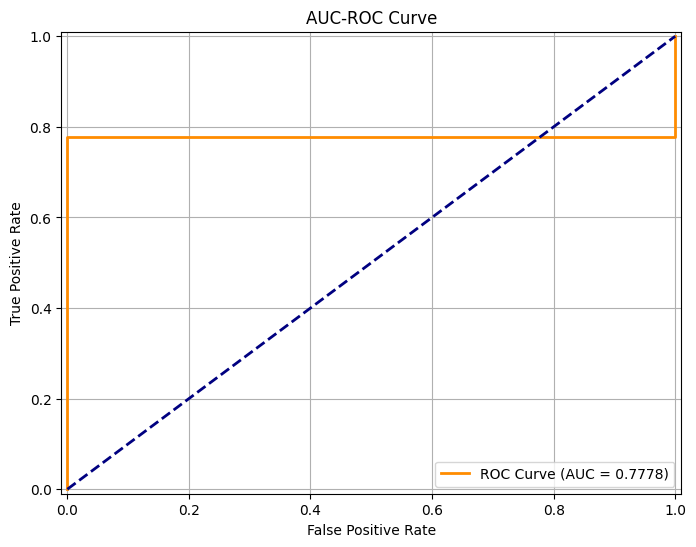

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_true: list or numpy array of true labels (0 or 1)
# y_probs: list or numpy array of predicted probabilities (between 0 and 1 for class 1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


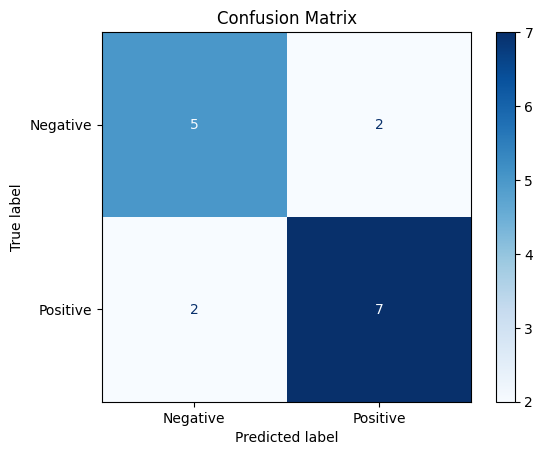

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# After evaluating the model:
# y_true: true labels
# y_pred: predicted labels (not probabilities, but class indices 0 or 1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
